<a href="https://colab.research.google.com/github/Ricardojnf33/NLP_Pipline_ACL_IMDB_sentiment_analyses/blob/main/NLP_Pipline_ACL_IMDB_sintment_analyses_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from glob import glob
from os import path
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import accuracy_score

import string

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import re
import pickle

from sklearn import svm
from sklearn import metrics

from nltk import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer

from pysummarization.nlpbase.auto_abstractor import AutoAbstractor
from pysummarization.tokenizabledoc.simple_tokenizer import SimpleTokenizer
from pysummarization.abstractabledoc.top_n_rank_abstractor import TopNRankAbstractor

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!git clone https://github.com/Ricardojnf33/NLP_Pipline_ACL_IMDB_sentiment_analyses.git

fatal: destination path 'NLP_Pipline_ACL_IMDB_sentiment_analyses' already exists and is not an empty directory.


# Setup

## Path - train

In [ ]:
# train dataset
input_path1 = '/content/NLP_Pipline_ACL_IMDB_sentiment_analyses/train'
# CSV output
output_path1 = '/content/ACL_IMDB_train.csv'

## Obter lista de "Paths" de arquivos de texto

In [ ]:
txt_path1_pos = glob( input_path1 + '/pos/*.txt') 
txt_path1_neg = glob( input_path1 + '/neg/*.txt')
print("Files found (positive reviews): ", len(txt_path1_pos))
print("Files found (negative reviews): ", len(txt_path1_neg))

Files found (positive reviews):  12500
Files found (negative reviews):  12500


## Funções auxiliares

In [ ]:
def get_text_from_file(path):
    with open(path, 'r') as file:
        return file.read()

# Criação do DataFrame

Os valores da coluna de classe são derivados dos nomes das subpastas no "input_path".

A coluna de imagem contém o "path" relativo para as imagens nas subpastas.

In [ ]:
# Create dataframe containing positive reviews
df_pos = pd.DataFrame({'review': txt_path1_pos})
df_pos.insert(loc=1, column='sentiment', value= 'positive')
# Create dataframe containing negative reviews
df_neg = pd.DataFrame({'review': txt_path1_neg})
df_neg.insert(loc=1, column='sentiment', value= 'negative')
# Concatenate dataframes containing positive and negative reviews
df = pd.concat([df_pos, df_neg])
# Replace path with review text
df['review'] = df['review'].apply(lambda path: get_text_from_file(path))
# Shuffle the rows to ensure that both examples of both clases are displayed in the Dataset previw on the Platform.
df = df.sample(frac=1.0, random_state=1)
df.head()

,review,sentiment
8992,The film starts to slowly when we got to the c...,negative
9488,Have to be honest and say that I haven't seen ...,positive
4433,Almost from the word go this film is poor and ...,negative
104,Linda Lovelace was the victim of a sadistic wo...,negative
8222,Have not seen this 1958 film in a very long ti...,positive


# Cálculo da forma ideal da coluna de revisão na plataforma
Adicione uma coluna que contenha o número de palavras em cada revisão.

In [ ]:
df_stat = df.copy()
df_stat['word_count'] = df['review'].apply(lambda txt: len(txt.split(' ')))
df_stat.head()

,review,sentiment,word_count
8992,The film starts to slowly when we got to the c...,negative,157
9488,Have to be honest and say that I haven't seen ...,positive,73
4433,Almost from the word go this film is poor and ...,negative,227
104,Linda Lovelace was the victim of a sadistic wo...,negative,114
8222,Have not seen this 1958 film in a very long ti...,positive,155


###A plataforma irá truncar textos de revisão que tenham uma contagem de palavras que exceda o comprimento do vetor (forma). Um vetor longo normalmente dará um desempenho melhor, mas o modelo levará mais tempo para treinar.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


Minimum word count required to include all words in 95.0% of the reviews: 598.0


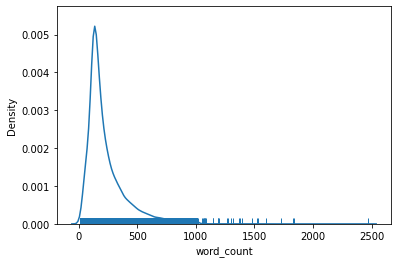

In [ ]:
q=0.95
x = df_stat['word_count']
sns.distplot(x, hist=False, rug=True);
print('Minimum word count required to include all words in {}% of the reviews: {}'.format(q*100, x.quantile(q)))

In [ ]:
movies_data_wc = pd.concat([df_stat, df])

In [ ]:
movies_data_wc

,review,sentiment,word_count
8992,The film starts to slowly when we got to the c...,negative,157.0
9488,Have to be honest and say that I haven't seen ...,positive,73.0
4433,Almost from the word go this film is poor and ...,negative,227.0
104,Linda Lovelace was the victim of a sadistic wo...,negative,114.0
8222,Have not seen this 1958 film in a very long ti...,positive,155.0
...,...,...,...
10955,"Deliverance is a stunning thriller, every bit ...",positive,NaN
4789,I know that the real story of Little Richard i...,negative,NaN
5192,Here is proof of why Mary Pickford was `Americ...,positive,NaN
12172,I remember first watching Sabrina when it came...,positive,NaN


## Criação de CSV de Output train

In [ ]:
movies_data_wc.to_csv(output_path1, index = None, header=True)

## Carregando CSV train

In [ ]:
movies_data = pd.read_csv(output_path1)

In [ ]:
#Concat word_count
#movies_data_wc = pd.concat([df_stat, movies_data])

# Explorando os Dados

In [ ]:
movies_data.head()

,review,sentiment,word_count
0,The film starts to slowly when we got to the c...,negative,157.0
1,Have to be honest and say that I haven't seen ...,positive,73.0
2,Almost from the word go this film is poor and ...,negative,227.0
3,Linda Lovelace was the victim of a sadistic wo...,negative,114.0
4,Have not seen this 1958 film in a very long ti...,positive,155.0


In [ ]:
movies_data.tail()

,review,sentiment,word_count
49995,"Deliverance is a stunning thriller, every bit ...",positive,NaN
49996,I know that the real story of Little Richard i...,negative,NaN
49997,Here is proof of why Mary Pickford was `Americ...,positive,NaN
49998,I remember first watching Sabrina when it came...,positive,NaN
49999,"By 1945, and after a string of solid WWII prop...",positive,NaN


#### Como os Reviews se parecem?

In [ ]:
movies_data.review.loc[0]

"The film starts to slowly when we got to the cinema we thought it looked quite good but after about 5 mins we were all bored out of our minds and wondering what kind of film we had come to see, i don't like this film and wouldn't recommend it to anyone, the best part of the night was when the alarm and lights came back on because the project broke down because we thought we could all go home. this has to be one of the worst films i have ever seen we were all bored out of or minds and most of the people in the cinema actually RAN out of the doors at the end because it was so rubbish. i am surprised that no one walked out earlier than that. if you go and see it make sure you something to keep you busy, better still Don't go and see it at all."

In [ ]:
movies_data.review.loc[24999]

'By 1945, and after a string of solid WWII propaganda pieces, Errol Flynn’s hold over U.S. box office had started to decline so, in spite of the increased burden of waning looks, he embarked on a series of films pertaining to that genre which had earlier made his name: the swashbuckler. The first of these was a good one actually – ADVENTURES OF DON JUAN (1948) – but it also proved to be his last big-budget Hollywood starring vehicle. The rest of his sword-wielding days were spent wandering all over Europe: in England for KIM (1950), THE MASTER OF BALLANTRAE (1953) and THE DARK AVENGER (1955), in France for ADVENTURES OF CAPTAIN FABIAN (1951) and Italy for the aborted THE STORY OF WILLIAM TELL (1953) and the little-seen CROSSED SWORDS (1954). However, Hollywood did beckon him one last time to his old seafaring ways – albeit for a modestly-budgeted Universal picture rather than a Warner Brothers ‘A’ production to which he had been accustomed when at his peak… <br /><br />Still, the glori

#### Qual a duração dos Reviews ? Qual o Reviews mais longo? Reviews mais curta?

In [ ]:
movies_data.dropna( inplace=True)

In [ ]:
movies_data.count()

review        25000
sentiment     25000
word_count    25000
dtype: int64

In [ ]:
movies_data['word_count_length'] = movies_data.review.apply(len)

In [ ]:
movies_data['word_count_length'].mean()

1325.06964

In [ ]:
movies_data['word_count_length'].min()

52

In [ ]:
movies_data['word_count_length'].max()

13704

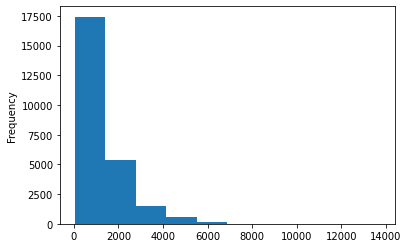

In [ ]:
movies_data.word_count_length.plot.hist()

##### Quais são as palavras mais frequentes nos reviews? Nos reviews de um sentimento específico?

In [ ]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, output_path1)).read()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=STOPWORDS).generate(str(text))

(-0.5, 399.5, 199.5, -0.5)

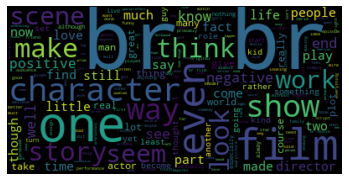

In [ ]:
# Display the generated image:
# the matplotlib way:

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Limpeza e Pré-processamento de Dados
#### Removendo as descrições mais curtas

In [ ]:
movies_data = movies_data.loc[movies_data["word_count_length"] > 33]

In [ ]:
movies_data.word_count_length.min()

52

#### Removendo pontuação

In [ ]:
exclude = set(string.punctuation)
def remove_punctoation(row):
  row.review = ''.join(ch for ch in row.review if ch not in exclude)
  return row

In [ ]:
movies_data = movies_data.apply(remove_punctoation, axis = 1)

In [ ]:
movies_data.tail()

,review,sentiment,word_count,word_count_length
24995,Deliverance is a stunning thriller every bit a...,positive,515.0,3010
24996,I know that the real story of Little Richard i...,negative,56.0,314
24997,Here is proof of why Mary Pickford was America...,positive,263.0,1484
24998,I remember first watching Sabrina when it came...,positive,143.0,735
24999,By 1945 and after a string of solid WWII propa...,positive,608.0,3566


#### Lemmatisation
##### https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
##### É o processo de agrupar as diferentes formas flexionadas de uma palavra para que possam ser analisadas como um único item. A "Lemmatisation" é semelhante à "stemming", mas traz contexto para as palavras. Por isso, liga palavras com significados semelhantes a uma palavra).
##### O pré-processamento de texto inclui tanto Stemming quanto Lematization. Muitas vezes as pessoas acham esses dois termos confusos. Alguns tratam esses dois como iguais. Na verdade, a lematização é preferível ao Stemming porque a Lematization faz a análise morfológica das palavras.


In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(row):
  row.review = " ".join(lemmatizer.lemmatize(word) for word in row.review.split())
  return row

In [ ]:
movies_data = movies_data.apply(lemmatize_text, axis = 1)

In [ ]:
movies_data.head()

,review,sentiment,word_count,word_count_length
0,The film start to slowly when we got to the ci...,negative,157.0,750
1,Have to be honest and say that I havent seen m...,positive,73.0,440
2,Almost from the word go this film is poor and ...,negative,227.0,1196
3,Linda Lovelace wa the victim of a sadistic wom...,negative,114.0,651
4,Have not seen this 1958 film in a very long ti...,positive,155.0,819


# Convertendo Dados em Vetores

#### Count Vectorizer
#### https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
#vectorizer = CountVectorizer(lowercase = True, stop_words=STOPWORDS, max_features= 2000)
#count_vectors = vectorizer.fit_transform(movies_data_wc.review)

In [ ]:
#count_vectors.toarray()
#count_vect = CountVectorizer(stop_words=None, min_df=.001, max_df=.95, max_features=1000)

In [ ]:
count_vect = CountVectorizer(stop_words='english')
count_vect.fit(movies_data.review)

CountVectorizer(stop_words='english')

In [ ]:
print('Tamanho do vocabulário: ', len(count_vect.vocabulary_))
counter = 0
for _, count in count_vect.vocabulary_.items():
    counter += count
    
print('Quantidade total de palavras: ', counter)

Tamanho do vocabulário:  115536
Quantidade total de palavras:  6674225880


In [ ]:
for i, (token, count) in enumerate(count_vect.vocabulary_.items()):
    if i > 20:
        break
    print(token, count)

film 37775
start 96987
slowly 94137
got 43578
cinema 19786
thought 102816
looked 60514
quite 82310
good 43245
min 65757
bored 13815
mind 65768
wondering 113319
kind 56348
come 21323
dont 30095
like 59507
wouldnt 113766
recommend 83784
best 11658
night 70375


In [ ]:
# Write DataFrame to CSV File with new params.
movies_data.to_csv(output_path1,mode='w+')

#Path 2

In [ ]:
# Raw dataset
#input_path2 = './content/data_train.csv'
# CSV output
#output_path2 = './data_ACL_IMDB_train.csv'

# Obter base de treino

In [ ]:
dftrain = pd.read_csv(output_path1)

In [ ]:
dftrain['sentiment_boolean'] = dftrain['sentiment'].map({'positive': True, 'negative': False})

In [ ]:
#d = {'positive': True, 'negative': False}
#dftrain["sentiment"].map(d)

In [ ]:
#d

In [ ]:
#movies_data_train = d
#movies_data_train = movies_data_train[movies_data_train.sentiment == 'False']

In [ ]:
dftrain

,Unnamed: 0,review,sentiment,word_count,word_count_length,sentiment_boolean
0,0,The film start to slowly when we got to the ci...,negative,157.0,750,False
1,1,Have to be honest and say that I havent seen m...,positive,73.0,440,True
2,2,Almost from the word go this film is poor and ...,negative,227.0,1196,False
3,3,Linda Lovelace wa the victim of a sadistic wom...,negative,114.0,651,False
4,4,Have not seen this 1958 film in a very long ti...,positive,155.0,819,True
...,...,...,...,...,...,...
24995,24995,Deliverance is a stunning thriller every bit a...,positive,515.0,3010,True
24996,24996,I know that the real story of Little Richard i...,negative,56.0,314,False
24997,24997,Here is proof of why Mary Pickford wa Americas...,positive,263.0,1484,True
24998,24998,I remember first watching Sabrina when it came...,positive,143.0,735,True


### Iniciando a contagem de vocabulário da classe de interesse no train set

In [ ]:
count_vect = CountVectorizer(stop_words=None, min_df=.001, max_df=.95, max_features=1000)
count_vect.fit(dftrain.review)

CountVectorizer(max_df=0.95, max_features=1000, min_df=0.001)

In [ ]:
print('Tamanho do vocabulário: ', len(count_vect.vocabulary_))
counter = 0
for _, count in count_vect.vocabulary_.items():
    counter += count
    
print('Quantidade total de palavras: ', counter)

Tamanho do vocabulário:  1000
Quantidade total de palavras:  499500


In [ ]:
for i, (token, count) in enumerate(count_vect.vocabulary_.items()):
    if i > 33:
        break
    print(token, count)

film 317
start 801
to 872
when 950
we 939
got 371
cinema 158
thought 865
it 451
looked 508
quite 684
good 369
but 128
after 24
about 7
were 945
all 31
out 621
of 597
our 620
mind 546
what 947
kind 472
had 379
come 167
see 740
dont 234
like 498
this 862
wouldnt 982
recommend 697
anyone 51
best 102
part 627


### Comparação do Vocabulário Global com o train Set

In [ ]:
count_vect_global = CountVectorizer(stop_words=None, min_df=.001, max_df=.95, max_features=3000)

count_vect_global.fit(dftrain.review)

CountVectorizer(max_df=0.95, max_features=3000, min_df=0.001)

In [ ]:
print('Tamanho do vocabulário: ', len(count_vect_global.vocabulary_))
counter = 0
for _, count in count_vect_global.vocabulary_.items():
    counter += count
    
print('Quantidade total de palavras: ', counter)

Tamanho do vocabulário:  3000
Quantidade total de palavras:  4498500


### Criação de método para extrair as chaves do Dict que são os vocabulários

In [ ]:
def getList(dict):
    return list(dict.keys())

targetList = getList(count_vect.vocabulary_)

globalList = getList(count_vect_global.vocabulary_)

In [ ]:
print(targetList)
print(" ")
print(globalList)

['film', 'start', 'to', 'when', 'we', 'got', 'cinema', 'thought', 'it', 'looked', 'quite', 'good', 'but', 'after', 'about', 'were', 'all', 'out', 'of', 'our', 'mind', 'what', 'kind', 'had', 'come', 'see', 'dont', 'like', 'this', 'wouldnt', 'recommend', 'anyone', 'best', 'part', 'night', 'wa', 'light', 'came', 'back', 'on', 'because', 'project', 'down', 'could', 'go', 'home', 'ha', 'be', 'one', 'worst', 'have', 'ever', 'seen', 'or', 'most', 'people', 'in', 'actually', 'at', 'end', 'so', 'am', 'surprised', 'that', 'no', 'earlier', 'than', 'if', 'you', 'make', 'sure', 'something', 'keep', 'better', 'still', 'say', 'havent', 'many', 'very', 'well', 'done', 'direction', 'cinematography', 'without', 'setting', 'used', 'world', 'which', 'main', 'character', 'memorable', 'image', 'from', 'stick', 'your', 'long', 'over', 'always', 'director', 'almost', 'word', 'is', 'poor', 'then', 'again', 'would', 'show', 'script', 'dialogue', 'really', 'doe', 'not', 'sometimes', 'case', 'more', 'le', 'should

### Concat das listas dos vocabulários

In [ ]:
masterList = targetList + globalList

In [ ]:
len(masterList)

4000

### Criação de um conjunto (set) para a eliminação de palavras repetidas

In [ ]:
setVocabulary = set(masterList)

In [ ]:
print(type(setVocabulary))
len(setVocabulary)

<class 'set'>


3000

In [ ]:
print(setVocabulary)

{'demand', 'actor', 'show', 'provided', 'slightly', 'male', 'source', 'greatly', 'bird', 'home', 'between', 'belief', 'obvious', 'couldve', 'everybody', 'cut', 'bride', 'got', 'ludicrous', 'moviebr', 'up', 'shallow', 'strongly', 'rebel', 'every', 'historical', 'storyline', 'convince', 'hate', 'news', 'essentially', 'terrible', 'regarding', 'compare', 'abandoned', 'facial', 'pacino', 'ultimate', 'correct', 'played', 'buck', 'caused', 'rate', 'stylish', 'honor', 'warner', 'piece', 'sky', 'sell', 'wont', 'doesnt', 'guilty', 'status', 'encounter', 'game', 'previous', 'reason', 'hilarious', 'happiness', '12', 'jr', 'nowadays', 'involving', 'return', 'ensemble', 'older', 'rough', 'looked', 'company', 'fashion', 'realized', 'terror', 'fame', 'surprised', 'stone', '1980s', 'format', 'mansion', 'par', 'surprisingly', 'support', 'away', 'proved', 'sign', 'print', 'bound', 'do', 'warned', 'lucy', 'yourself', 'setup', 'usually', 'continue', 'contact', 'industry', 'memory', 'santa', 'treasure', 'ri

In [ ]:
masterList = list(setVocabulary)

## Recriação do vocabulário

In [ ]:
count_vect_final = CountVectorizer(stop_words=None, vocabulary=masterList)

count_vect_final.fit(dftrain.review)

CountVectorizer(vocabulary=['demand', 'actor', 'show', 'provided', 'slightly',
                            'male', 'source', 'greatly', 'bird', 'home',
                            'between', 'belief', 'obvious', 'couldve',
                            'everybody', 'cut', 'bride', 'got', 'ludicrous',
                            'moviebr', 'up', 'shallow', 'strongly', 'rebel',
                            'every', 'historical', 'storyline', 'convince',
                            'hate', 'news', ...])

#### TF IDF vectorizer
#### https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
#TFIDF_vectorizer = TfidfVectorizer(lowercase = True, stop_words=STOPWORDS, max_features = 2000)
#tfidf_vectors = TFIDF_vectorizer.fit_transform(movies_data.review)

In [ ]:
#tfidf_vectors.toarray()

In [ ]:
Xcountvect = count_vect_final.transform(dftrain.review)

In [ ]:
Xcountvect.shape

(25000, 3000)

In [ ]:
print(Xcountvect[0,:])

  (0, 9)	1
  (0, 17)	1
  (0, 67)	1
  (0, 73)	1
  (0, 166)	1
  (0, 212)	1
  (0, 239)	1
  (0, 254)	1
  (0, 308)	1
  (0, 331)	1
  (0, 334)	1
  (0, 361)	3
  (0, 383)	1
  (0, 439)	1
  (0, 440)	1
  (0, 448)	1
  (0, 455)	2
  (0, 459)	5
  (0, 505)	2
  (0, 506)	1
  (0, 514)	1
  (0, 532)	2
  (0, 544)	2
  (0, 580)	2
  (0, 595)	4
  :	:
  (0, 1905)	1
  (0, 2033)	1
  (0, 2195)	1
  (0, 2208)	2
  (0, 2260)	4
  (0, 2264)	7
  (0, 2271)	1
  (0, 2435)	2
  (0, 2474)	1
  (0, 2485)	1
  (0, 2509)	1
  (0, 2530)	2
  (0, 2559)	1
  (0, 2567)	1
  (0, 2586)	1
  (0, 2595)	1
  (0, 2599)	1
  (0, 2632)	1
  (0, 2649)	1
  (0, 2667)	1
  (0, 2720)	1
  (0, 2738)	1
  (0, 2760)	1
  (0, 2904)	2
  (0, 2990)	1


In [ ]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(Xcountvect)

TfidfTransformer()

In [ ]:
X_tfidf = tfidf_transformer.transform(Xcountvect)
print(X_tfidf[0,:])

  (0, 2990)	0.062665044801055
  (0, 2904)	0.10612672082094943
  (0, 2760)	0.045889338838507515
  (0, 2738)	0.04384571552581684
  (0, 2720)	0.031443865234819894
  (0, 2667)	0.08653474426055882
  (0, 2649)	0.13276376517709323
  (0, 2632)	0.0635011891302622
  (0, 2599)	0.0666820356160175
  (0, 2595)	0.03449260364855339
  (0, 2586)	0.026415783194457858
  (0, 2567)	0.0448136724725482
  (0, 2559)	0.14380639037239967
  (0, 2530)	0.06744148299386302
  (0, 2509)	0.06995707069042255
  (0, 2485)	0.06000706306818503
  (0, 2474)	0.06701137354218749
  (0, 2435)	0.1897766249280627
  (0, 2271)	0.043485356119724906
  (0, 2264)	0.41160192559389364
  (0, 2260)	0.15631161365600654
  (0, 2208)	0.05727070005399021
  (0, 2195)	0.07890132916988031
  (0, 2033)	0.08432378020378185
  (0, 1905)	0.049312764988067866
  :	:
  (0, 595)	0.14534278050632882
  (0, 580)	0.09467458779956178
  (0, 544)	0.07374070408932631
  (0, 532)	0.17084604432748343
  (0, 514)	0.0640898752653472
  (0, 506)	0.036880338345197695
  (0, 505

In [ ]:
X_tfidf.shape

(25000, 3000)

In [ ]:
print(X_tfidf)

  (0, 2990)	0.062665044801055
  (0, 2904)	0.10612672082094943
  (0, 2760)	0.045889338838507515
  (0, 2738)	0.04384571552581684
  (0, 2720)	0.031443865234819894
  (0, 2667)	0.08653474426055882
  (0, 2649)	0.13276376517709323
  (0, 2632)	0.0635011891302622
  (0, 2599)	0.0666820356160175
  (0, 2595)	0.03449260364855339
  (0, 2586)	0.026415783194457858
  (0, 2567)	0.0448136724725482
  (0, 2559)	0.14380639037239967
  (0, 2530)	0.06744148299386302
  (0, 2509)	0.06995707069042255
  (0, 2485)	0.06000706306818503
  (0, 2474)	0.06701137354218749
  (0, 2435)	0.1897766249280627
  (0, 2271)	0.043485356119724906
  (0, 2264)	0.41160192559389364
  (0, 2260)	0.15631161365600654
  (0, 2208)	0.05727070005399021
  (0, 2195)	0.07890132916988031
  (0, 2033)	0.08432378020378185
  (0, 1905)	0.049312764988067866
  :	:
  (24999, 396)	0.041547533493589923
  (24999, 393)	0.05082336287137859
  (24999, 386)	0.0600957302663869
  (24999, 370)	0.13023854870577425
  (24999, 363)	0.07809078794776893
  (24999, 362)	0.064

# Modelagem de tópicos usando SVD
#### A quantidade de tópicos pode ser analisada pela variabilidade explicada.

In [ ]:
svd = TruncatedSVD(n_components=100, n_iter=10 , random_state=0)
svd.fit(X_tfidf)

TruncatedSVD(n_components=100, n_iter=10, random_state=0)

# Matriz V
#### Criar figura heatmap com os componentes do SVD. Com ela, você consegue visualizar quais são os termos mais importantes dentro de cada tópico

In [ ]:
V = svd.components_
print(V.shape)
print(list(sorted(V[2,:], reverse=True))[0:3])

(100, 3000)
[0.502068236297567, 0.403122798221244, 0.3170677009458092]


In [ ]:
print('Total de variabilidade explicada: ', sum(svd.explained_variance_ratio_))

Total de variabilidade explicada:  0.21412032354940938


In [ ]:
X_lsa = svd.transform(X_tfidf) # Matriz U do SVD => documentos x tópicos

# Para entender os tópicos de um documento, liste os mais importantes, em seguida substitua o id do tópico pelos top-k tokens desse tópico.

In [ ]:
top_3_importance = list(sorted(X_lsa[0,:], reverse=True))[0:3]
print(top_3_importance)

[0.3984133466932583, 0.16503812220098024, 0.14286508106582413]


# Construindo um classificador de texto

In [ ]:
rf_clf_tfidf = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_features=5, max_depth=5, oob_score=True, verbose=2, random_state=0, class_weight="balanced_subsample")

## Treinando uma RandomForest com as features TF-IDF dos documentos

In [ ]:
y = dftrain["sentiment_boolean"]
y

0        False
1         True
2        False
3        False
4         True
         ...  
24995     True
24996    False
24997     True
24998     True
24999     True
Name: sentiment_boolean, Length: 25000, dtype: bool

In [ ]:
rf_clf_tfidf.fit(X_tfidf, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500building tree 4 of 500

building tree 5 of 500
building tree 6 of 500building tree 7 of 500

building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500building tree 33 of 500

building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.8s



building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500building tree 51 of 500

building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500building tree 70 of 500

building tree 71 of 500
building tree 72 of 500
building tree 73 of 500building tree 74 of 500

building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500building tree 79 of 500

building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 8

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    3.3s


building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500building tree 185 of 500

building tree 186 of 500building tree 187 of 500

building tree 188 of 500building tree 189 of 500

building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500building tree 199 of 500

building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500


[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:    6.3s


building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500building tree 403 of 500

building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.0s finished


RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       max_features=5, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=0, verbose=2)

In [ ]:
print(rf_clf_tfidf.feature_importances_)

[0.00000000e+00 6.73741997e-05 5.99722106e-04 ... 1.90808135e-03
 6.47692575e-03 2.24404538e-03]


In [ ]:
print('Média da acurácia das classes: ', rf_clf_tfidf.score(X_tfidf, y))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    2.4s


Média da acurácia das classes:  0.85388


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    3.3s finished


## Treinando uma RandomForest com as features LSA (tópicos) dos documentos

In [ ]:
rf_clf_lsa = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_features=5, max_depth=5, oob_score=True, verbose=2, random_state=0, class_weight="balanced_subsample")
rf_clf_lsa.fit(X_lsa, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500building tree 20 of 500

building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.1s


building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    8.9s


building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500building tree 175 of 500

building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500


[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   25.6s


building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   34.6s finished


RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       max_features=5, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=0, verbose=2)

In [ ]:
print(rf_clf_lsa.feature_importances_)

[0.01284959 0.09001549 0.02028223 0.00251777 0.01710038 0.01563726
 0.01944864 0.00688534 0.1795472  0.26814955 0.01424465 0.00631601
 0.06342945 0.00160526 0.01527066 0.01180182 0.00437806 0.00285091
 0.0166471  0.0066357  0.01792369 0.01473875 0.00197899 0.00698146
 0.00435924 0.00271296 0.00245029 0.00308742 0.00791077 0.00142785
 0.00231339 0.00249143 0.00333082 0.00274671 0.00167696 0.00135946
 0.00197658 0.00082814 0.00132545 0.00172908 0.00570229 0.00143349
 0.00168664 0.00371202 0.00229089 0.00322695 0.00498398 0.00110288
 0.00211114 0.00151954 0.00120754 0.00091761 0.00099383 0.00124972
 0.00254515 0.0016135  0.00117476 0.01472268 0.00155224 0.00118091
 0.00128579 0.00399746 0.00267767 0.00133263 0.00241659 0.00533093
 0.00262642 0.00138429 0.00231631 0.00123266 0.00734347 0.00466748
 0.00608224 0.00125097 0.00105405 0.00078799 0.00107766 0.00114116
 0.00099635 0.00315459 0.0012955  0.00111919 0.00114606 0.00122789
 0.00099211 0.0021657  0.00092137 0.00276693 0.00225254 0.0010

In [ ]:
print('Média da acurácia das classes: ', rf_clf_lsa.score(X_lsa, y))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    0.8s


Média da acurácia das classes:  0.80488


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.1s finished


# Obter base de test

In [ ]:
# Raw dataset
input_path2 = '/content/NLP_Pipline_ACL_IMDB_sentiment_analyses/test'
# CSV output
output_path2 = '/content/ACL_IMDB_test.csv'

## Obter lista de "Paths" de arquivos de texto

In [ ]:
txt_paths_pos_test = glob(input_path2 + '/pos/*.txt') 
txt_paths_neg_test = glob(input_path2 + '/neg/*.txt')
print("Files found (positive review): ", len(txt_paths_pos_test))
print("Files found (negative review): ", len(txt_paths_neg_test))

Files found (positive review):  12500
Files found (negative review):  12500


# Criação do dftest

Os valores da coluna de classe são derivados dos nomes das subpastas no "input_path2".

A coluna de imagem contém o "path" relativo para as imagens nas subpastas.

In [ ]:
# Create dataframe containing positive reviews
df_pos_test = pd.DataFrame({'review': txt_paths_pos_test})
df_pos_test.insert(loc=1, column='sentiment', value= 'positive')
# Create dataframe containing negative reviews
df_neg_test = pd.DataFrame({'review': txt_paths_neg_test})
df_neg_test.insert(loc=1, column='sentiment', value= 'negative')
# Concatenate dataframes containing positive and negative reviews
dftest = pd.concat([df_pos_test, df_neg_test])
# Replace path with review text
dftest['review'] = dftest['review'].apply(lambda path: get_text_from_file(path))
# Shuffle the rows to ensure that both examples of both clases are displayed in the Dataset previw on the Platform.
dftest = dftest.sample(frac=1.0, random_state=1)
dftest.head()

,review,sentiment
8992,This film is the proof that a good actor is no...,negative
9488,A while back I bought the Chinese box set of F...,positive
4433,I cannot believe that the actors agreed to do ...,negative
104,This movie has more goofs than any other movie...,negative
8222,"""Lackawanna Blues'is so emotionally powerful i...",positive


## Função Auxiliar

In [ ]:
def get_text_from_file(path):
    with open(path, 'r') as file:
        return file.read()

In [ ]:
dftest.to_csv('/content/ACL_IMDB_test.csv',mode='w+')

# Avaliação do classificador com a base teste

## Criação do set de test

In [ ]:
dftest = pd.read_csv('/content/ACL_IMDB_test.csv')

In [ ]:
dftest['sentiment_boolean'] = dftest['sentiment'].map({'positive': 1, 'negative': 0})

#### Removendo pontuação

In [ ]:
exclude = set(string.punctuation)
def remove_punctoation(row):
  row.review = ''.join(ch for ch in row.review if ch not in exclude)
  return row

In [ ]:
dftest = dftest.apply(remove_punctoation, axis = 1)

#### Lemmatisation

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(row):
  row.review = " ".join(lemmatizer.lemmatize(word) for word in row.review.split())
  return row

In [ ]:
dftest = dftest.apply(lemmatize_text, axis = 1)

In [ ]:
dftest

,Unnamed: 0,review,sentiment,sentiment_boolean
0,8992,This film is the proof that a good actor is no...,negative,0
1,9488,A while back I bought the Chinese box set of F...,positive,1
2,4433,I cannot believe that the actor agreed to do t...,negative,0
3,104,This movie ha more goof than any other movie I...,negative,0
4,8222,Lackawanna Bluesis so emotionally powerful in ...,positive,1
...,...,...,...,...
24995,10955,Separate LIES changed my life Actually the QA ...,positive,1
24996,4789,This movie is awful beyond belief Its a lowbud...,negative,0
24997,5192,As you can see I loved the book so much I use ...,positive,1
24998,12172,I saw this minimovie when it first aired and l...,positive,1


In [ ]:
# Obter a base de teste
test_documents = dftest.sentiment
y_test = dftest["sentiment_boolean"]

# Extração de características de contagem
Xcountvect_test = count_vect_final.transform(test_documents)
print('1a etapa de extração de características')
print(Xcountvect_test)

# Extração de características de frequência TF-IDF
X_tfidf_test = tfidf_transformer.transform(Xcountvect_test)
print('2a etapa de extração de características')
print(Xcountvect_test.shape)

# Extração dos embeddings
X_lsa_test = svd.transform(X_tfidf_test)
print('3a etapa de extração de características')
print(X_lsa_test.shape)

1a etapa de extração de características
  (0, 1950)	1
  (1, 2252)	1
  (2, 1950)	1
  (3, 1950)	1
  (4, 2252)	1
  (5, 2252)	1
  (6, 1950)	1
  (7, 1950)	1
  (8, 1950)	1
  (9, 2252)	1
  (10, 2252)	1
  (11, 1950)	1
  (12, 1950)	1
  (13, 2252)	1
  (14, 2252)	1
  (15, 2252)	1
  (16, 2252)	1
  (17, 2252)	1
  (18, 2252)	1
  (19, 1950)	1
  (20, 2252)	1
  (21, 1950)	1
  (22, 1950)	1
  (23, 1950)	1
  (24, 2252)	1
  :	:
  (24975, 1950)	1
  (24976, 1950)	1
  (24977, 1950)	1
  (24978, 2252)	1
  (24979, 1950)	1
  (24980, 2252)	1
  (24981, 1950)	1
  (24982, 2252)	1
  (24983, 1950)	1
  (24984, 1950)	1
  (24985, 1950)	1
  (24986, 2252)	1
  (24987, 2252)	1
  (24988, 2252)	1
  (24989, 1950)	1
  (24990, 1950)	1
  (24991, 2252)	1
  (24992, 1950)	1
  (24993, 1950)	1
  (24994, 2252)	1
  (24995, 2252)	1
  (24996, 1950)	1
  (24997, 2252)	1
  (24998, 2252)	1
  (24999, 2252)	1
2a etapa de extração de características
(25000, 3000)
3a etapa de extração de características
(25000, 100)


In [ ]:
print('[TF-IDF] Média da acurácia das classes: ', rf_clf_tfidf.score(X_tfidf_test, y_test))
print('[LSA features] Média da acurácia das classes: ', rf_clf_lsa.score(X_lsa_test, y_test))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.7s finished


[TF-IDF] Média da acurácia das classes:  0.5


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    0.7s


[LSA features] Média da acurácia das classes:  0.0


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.9s finished


In [ ]:
y_pred_lsa = rf_clf_lsa.predict(X_lsa_test)
print(y_pred_lsa)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    0.7s


[ True False  True ... False False False]


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.9s finished


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_true = dftest.sentiment_boolean

y_pred = y_pred_lsa

confusion_matrix(y_true, y_pred)

array([[    0, 12500],
       [12500,     0]])

In [ ]:
y_true

0        0
1        1
2        0
3        0
4        1
        ..
24995    1
24996    0
24997    1
24998    1
24999    1
Name: sentiment_boolean, Length: 25000, dtype: int64

In [ ]:
y_pred

array([ True, False,  True, ..., False, False, False])

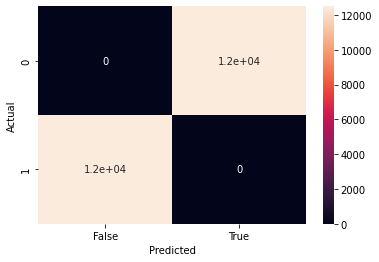

In [ ]:
data = {'y_Actual':    dftest["sentiment_boolean"],
        'y_Predicted': y_pred_lsa
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements

In [ ]:
print(confusion_matrix)

Predicted  False   True
Actual                 
0              0  12500
1          12500      0


In [ ]:
y_pred = y_pred_lsa
y_true = dftest["sentiment_boolean"]
accuracy_score(y_true, y_pred)

0.0

In [ ]:
accuracy_score(y_true, y_pred, normalize=False)

0

In [ ]:
print('Precision: %.3f' % precision_score(y_true, y_pred))

Precision: 0.000


In [ ]:
y_pred = y_pred_lsa
y_true = dftest["sentiment_boolean"]

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0. 0.]
recall: [0. 0.]
fscore: [0. 0.]
support: [12500. 12500.]


In [ ]:
from sklearn.metrics import classification_report

y_pred = y_pred_lsa
y_true = dftest["sentiment_boolean"]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00   12500.0
           1       0.00      0.00      0.00   12500.0

    accuracy                           0.00   25000.0
   macro avg       0.00      0.00      0.00   25000.0
weighted avg       0.00      0.00      0.00   25000.0



# Transformando o texto de uma query em vetores de características

In [ ]:
dftest

,Unnamed: 0,review,sentiment,sentiment_boolean
0,8992,This film is the proof that a good actor is no...,negative,0
1,9488,A while back I bought the Chinese box set of F...,positive,1
2,4433,I cannot believe that the actor agreed to do t...,negative,0
3,104,This movie ha more goof than any other movie I...,negative,0
4,8222,Lackawanna Bluesis so emotionally powerful in ...,positive,1
...,...,...,...,...
24995,10955,Separate LIES changed my life Actually the QA ...,positive,1
24996,4789,This movie is awful beyond belief Its a lowbud...,negative,0
24997,5192,As you can see I loved the book so much I use ...,positive,1
24998,12172,I saw this minimovie when it first aired and l...,positive,1


In [ ]:
# Pre processamento
query = ['film', 'one', 'play', 'look', 'see', 'positive', 'know', 'story', 'work', 'character', 'make', 'director', 'little', 'find', 'scene', 'even', 'show', 'people', 'well', 'made', 'life']

# Extração de características de contagem
X_query = count_vect_final.transform(query)
print('1a etapa de extração de características')
print(X_query)

# Extração de características de frequência TF-IDF
X_tfidf_query = tfidf_transformer.transform(X_query)
print('2a etapa de extração de características')
print(X_tfidf_query)

# Extração dos embeddings da query
X_lsa_query = svd.transform(X_tfidf_query)
print('3a etapa de extração de características')
print(X_lsa_query)

1a etapa de extração de características
  (0, 595)	1
  (1, 544)	1
  (2, 719)	1
  (3, 2658)	1
  (4, 361)	1
  (5, 2252)	1
  (6, 812)	1
  (7, 2606)	1
  (8, 2278)	1
  (9, 902)	1
  (10, 1905)	1
  (11, 2145)	1
  (12, 1761)	1
  (13, 1773)	1
  (14, 1687)	1
  (15, 2748)	1
  (16, 2)	1
  (17, 254)	1
  (18, 1032)	1
  (19, 2282)	1
  (20, 1927)	1
2a etapa de extração de características
  (0, 595)	1.0
  (1, 544)	1.0
  (2, 719)	1.0
  (3, 2658)	1.0
  (4, 361)	1.0
  (5, 2252)	1.0
  (6, 812)	1.0
  (7, 2606)	1.0
  (8, 2278)	1.0
  (9, 902)	1.0
  (10, 1905)	1.0
  (11, 2145)	1.0
  (12, 1761)	1.0
  (13, 1773)	1.0
  (14, 1687)	1.0
  (15, 2748)	1.0
  (16, 2)	1.0
  (17, 254)	1.0
  (18, 1032)	1.0
  (19, 2282)	1.0
  (20, 1927)	1.0
3a etapa de extração de características
[[ 1.43580561e-01 -1.28975843e-01 -3.42032587e-01 ...  2.86493311e-02
  -1.74572294e-02  1.55081813e-02]
 [ 8.55607350e-02  1.27591127e-03 -3.67742321e-02 ... -4.01851332e-03
   2.20605726e-02 -9.01363619e-03]
 [ 2.53251979e-02 -4.18051414e-02  1.3

#Recuperar documentos mais relevantes dada uma query

In [ ]:
print(X_lsa_query.shape)

(21, 100)


In [ ]:
# Matriz de vetores dos documentos -> X_lsa
# Vetor da query -> X_lsa_query
# Recuperar k documentos mais relevantes a query
k = 3

output_distances = pairwise_distances(X_lsa, X_lsa_query, metric='euclidean')[:,0]
sorted_distances = list(sorted(output_distances))[:k]
sorted_indexes = list(np.argsort(output_distances)[:k])

print(query)
for id_doc, dist in zip(sorted_indexes, sorted_distances):
    print('Doc id: ', id_doc, ' Distance: ', dist)

['film', 'one', 'play', 'look', 'see', 'positive', 'know', 'story', 'work', 'character', 'make', 'director', 'little', 'find', 'scene', 'even', 'show', 'people', 'well', 'made', 'life']
Doc id:  14072  Distance:  0.719576280170402
Doc id:  24986  Distance:  0.7238294378977631
Doc id:  141  Distance:  0.7500102780341615


In [ ]:
rf_clf_tfidf.predict(X_tfidf_query)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

# Sumarização de conteúdo
https://github.com/accel-brain/accel-brain-code/tree/master/Automatic-Summarization/


### **pysummarization** é uma biblioteca de sumarização automática feita pela Accel Brain Co.,Ltd. Usando um tipo de processamento de linguagem natural e modelo de linguagem de rede neural. Essa biblioteca permite que você crie um resumo com os principais pontos do documento original ou texto extraído da web, filtrado por agrupamento de texto. E esta biblioteca aplica o accel-brain-base para implementar o Encoder/Decoder baseado em LSTM melhorando a precisão da sumarização por aprendizado de Sequence-to-Sequence(Seq2Seq).

In [ ]:
!pip install pysummarization

In [ ]:
query

['film',
 'one',
 'play',
 'look',
 'see',
 'positive',
 'know',
 'story',
 'work',
 'character',
 'make',
 'director',
 'little',
 'find',
 'scene',
 'even',
 'show',
 'people',
 'well',
 'made',
 'life']

In [ ]:
' '.join(str(e) for e in query)

'film one play look see positive know story work character make director little find scene even show people well made life'

In [ ]:
# Object of automatic summarization.
auto_abstractor = AutoAbstractor()
# Set tokenizer.
auto_abstractor.tokenizable_doc = SimpleTokenizer()
# Set delimiter for making a list of sentence.
auto_abstractor.delimiter_list = [".", "\n"]
# Object of abstracting and filtering document.
abstractable_doc = TopNRankAbstractor()
# Summarize document.
result_dict = auto_abstractor.summarize(' '.join(str(e) for e in query), abstractable_doc)

# Output result.
for sentence in result_dict["summarize_result"]:
    print(sentence)

film one play look see positive know story work character make director little find scene even show people well made life.



In [ ]:
result_dict

{'scoring_data': [(0, 20.0)],
 'summarize_result': ['film one play look see positive know story work character make director little find scene even show people well made life.\n']}

In [ ]:
# summarize_result: The list of summarized sentences 
# scoring_data:     The list of scores(Rank of importance)